<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/stablePeriodicPatterns/basic/SPPECLAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Stable Periodic Frequent patterns in Temporal Databases using SPPECLAT

This tutorial has two parts. In the first part, we describe the basic approach to find Stable Periodic Frequent patterns in a temporal database using the SPPECLAT algorithm. In the final part, we describe an advanced approach, where we evaluate the SPPECLAT algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=fd484ff8ac381c44c61362647242f8f2d6fa41b5f35537fc8b94da28e2e2991e
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=f41ff4580b83a0c83dd2f991238708d21846a6f285a43ea9e16611e66f1a9b51
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-09-05 16:50:04--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M   919KB/s    in 7.5s    

2023-09-05 16:50:13 (599 KB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Stable Periodic Frequent patterns using SPPECLAT

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.temporalDatabaseStats as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.temporalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

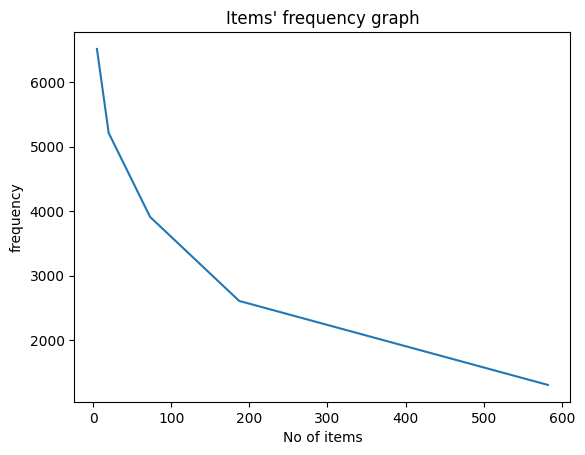

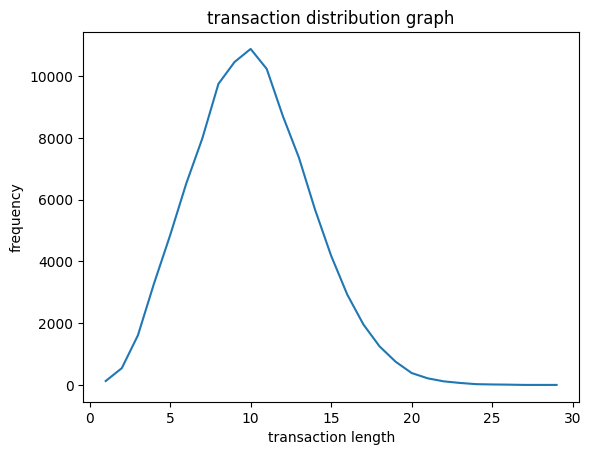

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minimumSupportCount = 100  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
maximumPeriodCount = 5000  #maximumPeriodCount is specified in count. However, the users can also specify maximumPeriodCount between 0 and 1.
maxLaValue = 1000 #maxLaValue is specified in count. However, the users can also specify maxLaValue between 0 and 1.

### Step 4: Mining Stable Periodic Frequent patterns using SPPECLAT

In [8]:
from PAMI.stablePeriodicFrequentPattern.basic import SPPEclat as alg #import the algorithm

obj = alg.SPPEclat(inputFile=inputFile, minSup=minimumSupportCount, maxPer=maximumPeriodCount, maxLa=maxLaValue, sep='\t') #initialize
obj.startMine()            #start the mining process

obj.save('stablePeriodicFrequentPatternsAtMinSupCount100.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Stable Periodic Frequent patterns were generated successfully using basic algorithm 
Total No of patterns: 26959
Runtime: 750.3077821731567
Memory (RSS): 2241507328
Memory (USS): 2195099648


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [9]:
!head 'stablePeriodicFrequentPatternsAtMinSupCount100.txt'

368:7818:0 
529	368:639:0 
529	720	368:181:0 
529	676	720	368:157:0 
529	720	48	676	368:155:0 
529	319	720	48	676	368:153:0 
529	319	527	720	48	676	368:150:0 
529	319	527	352	720	48	676	368:149:0 
352	720	595	676	368	529	319	527	48:147:0 
529	319	527	595	720	48	676	368:148:0 


The storage format is: _stablePeriodicfrequentPattern:support_
***

## Part 2: Evaluating the SPPECLAT algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [10]:
#Import the libraries
from PAMI.stablePeriodicFrequentPattern.basic import SPPEclat as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
maximumPeriodCount = 5000
maxLaValue=1000
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of SPPECLAT

In [11]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'maximumPeriodCount', 'maxLaValue', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of SPPECLAT algorithm

### Step 3: Execute the algorithm at different minSup values

In [14]:
for minSupCount in minimumSupportCountList:
    obj = alg.SPPEclat(inputFile, minSup=minSupCount, maxPer=maximumPeriodCount, maxLa=maxLaValue, sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['SPPEclat', minSupCount, maximumPeriodCount, maxLaValue, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Stable Periodic Frequent patterns were generated successfully using basic algorithm 
Stable Periodic Frequent patterns were generated successfully using basic algorithm 
Stable Periodic Frequent patterns were generated successfully using basic algorithm 
Stable Periodic Frequent patterns were generated successfully using basic algorithm 
Stable Periodic Frequent patterns were generated successfully using basic algorithm 


### Step 4: Print the Result

In [15]:
print(result)

  algorithm  minSup  maximumPeriodCount  maxLaValue  patterns     runtime  \
0  SPPEclat     100                5000        1000     26959  743.577161   
1  SPPEclat     150                5000        1000     19115  556.540653   
2  SPPEclat     200                5000        1000     13235  417.171257   
3  SPPEclat     250                5000        1000      7674  283.871248   
4  SPPEclat     300                5000        1000      4529  198.811954   

       memory  
0  4106850304  
1  3623673856  
2  3314810880  
3  3133554688  
4  3126312960  


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

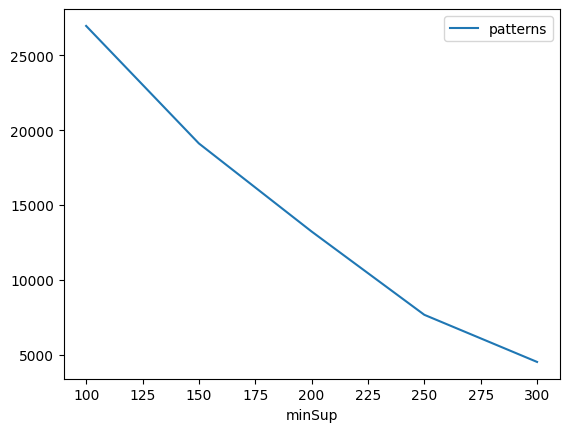

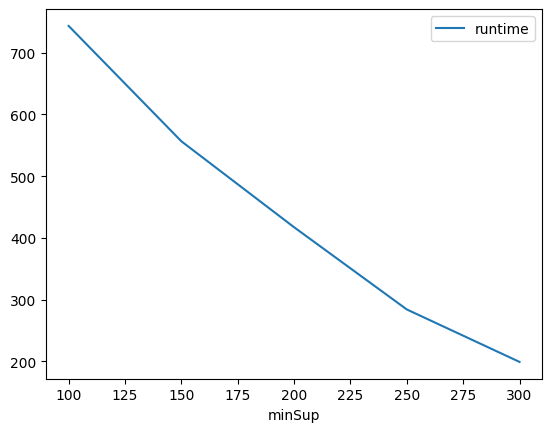

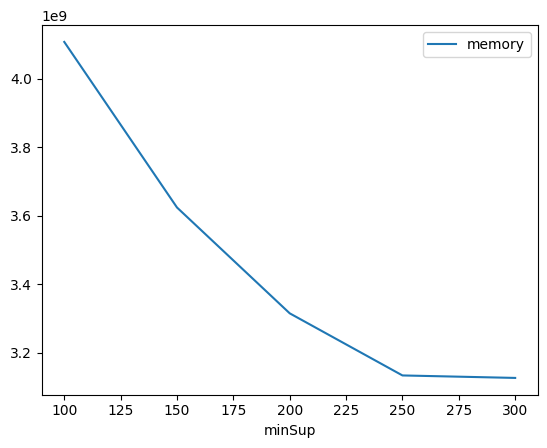

In [16]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib